project name: flexpart_management
created by diego aliaga daliaga_at_chacaltaya.edu.bo

imports

In [8]:
from sklearn.preprocessing import QuantileTransformer
from useful_scit.imps import *
# noinspection PyUnresolvedReferences
import matplotlib.colors
import flexpart_management.modules.FlexLogPol as FlexLogPol
import flexpart_management.modules.constants as co
# noinspection PyUnresolvedReferences
import flexpart_management.modules.flx_array as fa
import flexpart_management.modules.clustering_funs as cfuns
from sklearn.metrics import silhouette_samples

In [13]:

# ds = xr.open_mfdataset( [ co.latest_ds_mac ] , combine='by_coords' )

ds = fa.open_temp_ds_clustered_18()


In [14]:
ds

<xarray.Dataset>
Dimensions:                             (R_CENTER: 31, TH_CENTER: 36, ZMID: 30, releases: 4248)
Coordinates:
    LAT_00                              (R_CENTER, TH_CENTER) float64 -16.28 ... -0.3168
    GRIDAREA                            (R_CENTER, TH_CENTER) float64 2.42e+06 ... 1.235e+11
    LON_00                              (R_CENTER, TH_CENTER) float64 -68.13 ... -70.96
    ZBOT                                (ZMID) float64 0.0 500.0 ... 1.45e+04
    LON                                 (R_CENTER, TH_CENTER) float64 -68.05 ... -50.38
    TOPOGRAPHY                          (R_CENTER, TH_CENTER) float32 4691.927 ... 0.0
    ZTOP                                (ZMID) float64 500.0 1e+03 ... 1.5e+04
    LAT_01                              (R_CENTER, TH_CENTER) float64 -16.28 ... -0.06941
    LAT                                 (R_CENTER, TH_CENTER) float64 -16.27 ... 1.396
    LON_01                              (R_CENTER, TH_CENTER) float64 -68.12 ... -68.13
    LAT

In [15]:
conc_var = 'conc_smooth_norm'
lab = 'lab'
above_thre = 'above_thre'
# labs = ds[lab]
# dsc = ds[conc_var].to_dataset(co.RL)

In [16]:
# dsc

In [17]:

sel = {
    co.RL:slice(None,None,1),
    co.R_CENTER:slice(None,None,1),
    co.TH_CENTER:slice(None,None,1),
    co.ZM:slice(None,None,1),
}
ds_reset = ds.reset_coords()[[conc_var, lab, above_thre]]
ds_reset = ds_reset[sel].assign_coords({lab:ds_reset[lab]})
ds_new = ds_reset.where(ds_reset[above_thre]).drop(above_thre)
da = ds_new[conc_var].drop(lab)
df = da.load().to_dataframe()[conc_var].dropna()
dfu = df.unstack(co.RL)

In [18]:
dl = ds_new[lab].reset_coords(drop=True)
dlf =dl.to_dataframe()
dlf

lab
R_CENTER  TH_CENTER ZMID        
0.080460  0.087266  250.0      7
                    750.0      7
                    1250.0     7
                    1750.0     7
                    2250.0     7
...                          ...
17.814274 6.195919  12750.0    9
                    13250.0    9
                    13750.0   10
                    14250.0   10
                    14750.0   10

[33480 rows x 1 columns]

In [19]:

index = dfu.index
vals = dfu.loc[index]
labs = dlf.loc[index]

In [20]:

scaler = QuantileTransformer()
vals_quan = scaler.fit_transform( vals.T ).T * 1000
# vals_quan = vals*1000

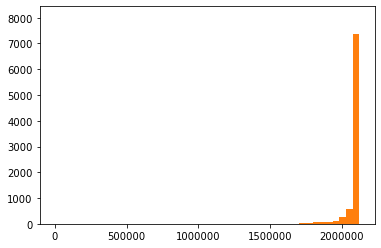

In [21]:
tot = vals.sum(axis=1)
plt.hist(tot)
plt.hist(vals_quan.sum(axis=1))
plt.show()

In [22]:
out_dic = {}
for n in range(2,25):
    print(n)
    from sklearn.cluster import KMeans
    new_lab = KMeans(n_clusters=n).fit_predict(vals_quan,sample_weight=100*tot)
    res = silhouette_samples(vals_quan, new_lab)
    res2 = silhouette_samples(vals_quan, new_lab, metric='l1')
    from sklearn.metrics import silhouette_score

    # print(silhouette_score(vals_quan, new_lab))
    wss = (res*tot).sum()/tot.sum()
    ss = res.mean()
    
    wss2 = (res2*tot).sum()/tot.sum()
    ss2 = res2.mean()
    print(wss)
    print(ss)
    dic = {
        'ss':ss,'wss':wss,'res':res,'new_lab':new_lab,
        'ss2':ss2,'wss2':wss2,'res':res2
    }
    out_dic[n]=dic

2
0.2840322221872885
0.28477572339988255
3
0.24071338537805634
0.24743914681946436
4
0.21146626057154475
0.217745703680589
5
0.19897747772111943
0.20012691149078543
6
0.20134972037369384
0.19974151283299107
7
0.19606424084366267
0.18659759238245072
8
0.19811304652620426
0.18933374137336237
9
0.20369448363927564
0.1935987250720606
10
0.2003311622083559
0.1878553630990674
11
0.19706003346206274
0.19054989836898026
12
0.1966548028064179
0.19025503701411314
13
0.19147199716855345
0.18677770012334624
14
0.18580818457895568
0.18102508371055276
15
0.19653658874896357
0.19077324236636517
16
0.19071993605043633
0.1835037514538652
17
0.1945289103524459
0.18534446175235844
18
0.19234469622029665
0.18552395051450016
19
0.19422908700450933
0.18962667955872708
20
0.19357424029615355
0.18610904343554074
21
0.19395845207113216
0.18662681970110084
22
0.20073097187918884
0.19171149342885263
23
0.1953586898318612
0.18771269739272567
24
0.19799371219015327
0.19111170185835122


In [24]:
df_dic = pd.DataFrame(out_dic).T

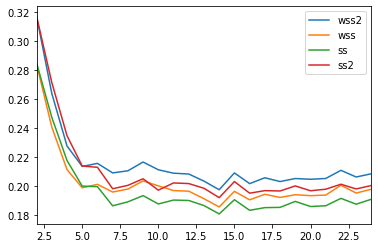

In [29]:
df_dic[['wss2','wss','ss','ss2']].plot()

In [ ]:
# df_dic.to_pickle(co.silhouette_path)
df_dic.to_pickle('/Users/diego/flexpart_management/flexpart_management/tmp_data/silhouette_scores_non.pickle')

In [3]:
df_dic = pd.read_pickle(co.silhouette_path)

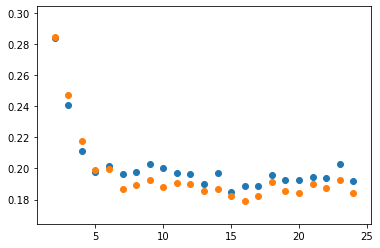

In [4]:
plt.scatter(df_dic.index,df_dic['wss'])
plt.scatter(df_dic.index,df_dic['ss'])
plt.show()

In [5]:
dlf['res']=np.nan
dlf['tot']=np.nan
dlf.loc[index,'res'] = res
dlf.loc[index,'tot'] = vals.sum(axis=1)

NameError: name 'dlf' is not defined

In [ ]:
ndf = dlf.loc[index].sort_values(['lab','res']).reset_index()
(ndf['res']*ndf['tot']).plot()
plt.show()

In [1]:
import numpy as np
a=0.08046 
b=0.09633 
c=0.1153

In [13]:
al=np.log(a)
bl=np.log(b)
cl=np.log(c)

In [14]:
bl-al

0.18001963024789003

In [15]:
cl-bl

0.1797576305054811

In [16]:
np.exp(bl+.18)

0.11532794858952398

In [12]:
np.exp(np.log(3))

3.0000000000000004

In [17]:
4248 * 31 *36 * 30

142223040

In [18]:
31 *36 * 30

33480

In [ ]:
ds[above_thre].reset_coords(drop=True).to_dataframe()[above_thre].value_counts()

In [ ]:
24900 + 8580

In [ ]:
dc = ds['CONC']
dcs = dc.sum(co.RL)
a = dcs.where(dcs<=0).count().load()

b = dcs.where(~ds[above_thre]).count().load()
a/b

In [ ]:
dcs.where(~ds[above_thre]).where(dcs>0).load().median()

In [ ]:
dcs.where(ds[above_thre]).load().median()

In [ ]:

dcs.where(ds[above_thre]).load().mean()